Use Python as the coding language and pandas dataframe and scikit-learn as the main tools for this task.

In [1]:
import pandas as pd
import numpy as np
import random
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core.common import SettingWithCopyWarning

np.random.seed(0)
random.seed(0)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
data = pd.read_csv('takehome_ds_written.csv', index_col=0)

C:\Users\ericz\AppData\Roaming\Python\Python39\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
data.head(10)

merchant                 time  amount_usd_in_cents
1   faa029c6b0  2034-06-17 23:34:14                 6349
2   ed7a7d91aa  2034-12-27 00:40:38                 3854
3   5608f200cf  2034-04-30 01:29:42                  789
4   15b1a0d61e  2034-09-16 01:06:23                 4452
5   4770051790  2034-07-22 16:21:42                20203
6   3fc4f08d9d  2034-08-12 10:54:48                 6190
7   1c8b539073  2033-03-10 18:46:49                  715
8   77f961f9b3  2034-12-09 21:27:18                 7211
9   9cb79b7700  2034-03-27 23:01:13                23267
10  2f95149dc3  2034-01-24 21:17:22                 2572

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1513719 entries, 1 to 1513719
Data columns (total 3 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   merchant             1513719 non-null  object
 1   time                 1513719 non-null  object
 2   amount_usd_in_cents  1513719 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 46.2+ MB


Find the year and month of every trade

In [5]:
data['Year_and_month'] = data['time'].apply(lambda s:s[:7])

In [6]:
data['time'] = pd.to_datetime(data['time'])

Observe the frequency distribution of merchant and time in this set of data occurs.

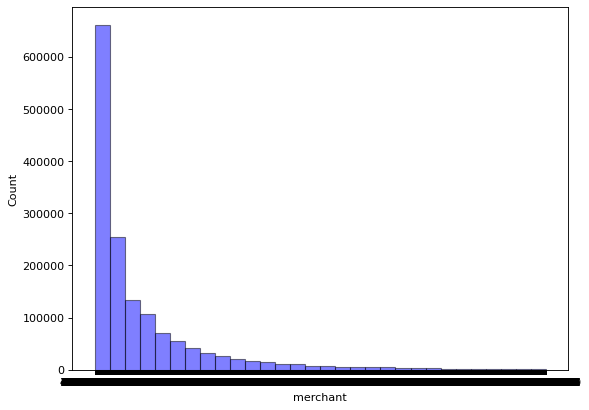

In [7]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(data.iloc[:,0], bins=30, edgecolor='k', facecolor='b', alpha=0.5)
plt.xlabel(data.columns[0])
plt.ylabel('Count')
plt.show()

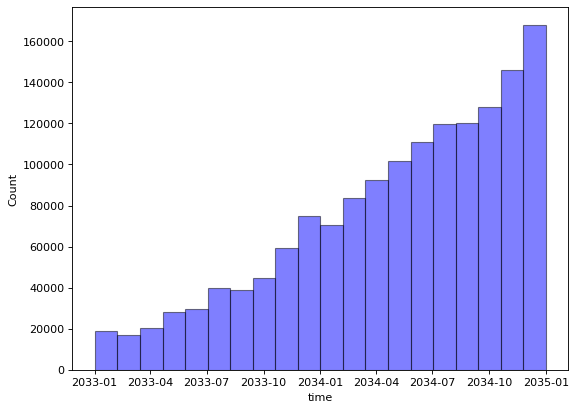

In [8]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(data.iloc[:,1], bins=20, edgecolor='k', facecolor='b', alpha=0.5)
plt.xlabel(data.columns[1])
plt.ylabel('Count')
plt.show()

Find out the total count/ frequency of each merchant appears in this dataset, and then sort the dataset in frequency descending and trade time ascending order.

In [9]:
data['Frequency'] = data.groupby('merchant')['merchant'].transform('count')
data_sort = data.sort_values(['Frequency', 'time'], ascending=[False, True])

Find out the year and month of each trade seperately.

In [10]:
data_sort['Year'] = pd.DatetimeIndex(data_sort['time']).year
data_sort['Month'] = pd.DatetimeIndex(data_sort['time']).month

Find out the trade count of each merchant monthly.

In [11]:
data_sort_process = data_sort.copy()
data_sort_process.loc[:,'Count_per_month'] = 0
data_sort_df = data_sort_process.groupby(['merchant','Year', 'Month']).agg({'Count_per_month':'count'}).reset_index()
data_sort_process.drop('Count_per_month', axis=1, inplace=True)
data_sort_process = data_sort_process.merge(data_sort_df, how = 'inner', on=['merchant','Year', 'Month'])

The following part is to find out the time order/ rank of current month from the total month in which the trade occurred by each merchant.
For example, if there are trades occur in January and March before the current month of April, 2033 for a particular merchant, then it should return the value 3. 

In [12]:
data_sort_process['Growth_rates_by_month'] = data_sort_process['Count_per_month']

In [13]:
data_sort_process['Rank_by_merchant'] = data_sort_process.groupby(["merchant"])["Year_and_month"].transform(lambda x: pd.factorize(x)[0] + 1).astype(int)

In [14]:
data_sort_process.loc[data_sort_process['Rank_by_merchant'] == 1, 'Growth_rates_by_month'] = 0

In [15]:
data_temp = data_sort_process[['merchant','Count_per_month', 'Rank_by_merchant']]

This part is to find out the retention rate by month of each merchant. Retention is the opposite of churning, in which it helps to keep track of how merchants are avoiding churning. If the renetion rate is positive for this month, then we can tell that this merchant is not losing the overall customers comparing with last month that happened trade. If this is the first month that happen trade throughout the dataset, we should return the monthly retention rate by 0.

In [16]:
data_temp.drop_duplicates(keep = 'first', inplace = True)
data_temp['Retention_rate_by_month (%)'] = data_temp.groupby('merchant')['Count_per_month'].apply(lambda x: x.pct_change().fillna(0)).to_numpy()

In [17]:
data_sort_process = data_sort_process.merge(data_temp, how='left', on=['merchant', 'Count_per_month', 'Rank_by_merchant'])

In [18]:
data_sort_process.head()

merchant                time  amount_usd_in_cents Year_and_month  \
0  5608f200cf 2033-03-29 21:21:57                  820        2033-03   
1  5608f200cf 2033-04-09 19:52:45                  382        2033-04   
2  5608f200cf 2033-04-10 02:23:28                  438        2033-04   
3  5608f200cf 2033-04-11 00:00:52                  820        2033-04   
4  5608f200cf 2033-04-11 00:45:22                  820        2033-04   

   Frequency  Year  Month  Count_per_month  Growth_rates_by_month  \
0      25512  2033      3                1                      0   
1      25512  2033      4              167                    167   
2      25512  2033      4              167                    167   
3      25512  2033      4              167                    167   
4      25512  2033      4              167                    167   

   Rank_by_merchant  Retention_rate_by_month (%)  
0                 1                          0.0  
1                 2                        166.0  
2                 2                        166.0  
3                 2                        166.0  
4                 2                        166.0

In [19]:
data_sort_ignore = data_sort_process.drop_duplicates(subset=['merchant', 'Year_and_month'], keep='first')

This part is to find out the overall retention rate by the entire time span of each merchant. If the total retention rate is positive, then we can tell that this merchant has an overall retention trend throughout the two year span. The larger the rate, the larger it will save customers from losing and prevent them from churning. Otherwise, when this number is negative, the lower the number, the higher the trend that this merchant is losing or has already lost customers. The algorithm I used is np.polyfit, which returns the concavity of the combining entire monthly retention rate.  A concavity that goes up means that it has a positive retention rate overall. 

However, I am not only using this element as the only factor to determine whether this merchant is churning or not.

In [20]:
dic_merchant = {}
dic_churn = {}
merchant_name = data_sort_ignore["merchant"].unique()
for name in merchant_name:
    merchant_lst = data_sort_ignore.groupby("merchant").get_group(name)["Rank_by_merchant"].tolist()
    churn_lst = data_sort_ignore.groupby("merchant").get_group(name)["Retention_rate_by_month (%)"].tolist()
    dic_merchant[name] = merchant_lst
    dic_churn[name] = churn_lst


In [21]:
def trendline(index, data):
    order = 1
    coeffs = np.polyfit(index, data, order)
    slope = coeffs[-2]
    return float(slope)

In [22]:
dic_total_rate = {}
for name in merchant_name:
    polyfit_result = trendline(dic_merchant[name],dic_churn[name])
    dic_total_rate[name] = polyfit_result

data_sort_ignore['Total_retention_rate (%)'] = data_sort_ignore['merchant'].apply(lambda x: dic_total_rate.get(x))
data_sort_ignore['Total_retention_rate (%)'].loc[data_sort_ignore['Total_retention_rate (%)'] == -0] = 0

<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_mer

<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_mer

<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_mer

<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_mer

<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_mer

<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_mer

<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_mer

<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_mer

<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant[name],dic_churn[name])
<ipython-input-22-7785ecba352c>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_mer

In this part, I am determining the quarter of every trade that happens. It is the standard calendar quarters that make up the year. It is another time factor to decide whether retention or churning. There will be a total of 1-8 quarters from a two year span and each quarter contains a maximum of three months. The quarterly span should be longer than monthly's, but shorter than totally's.

In [23]:
def determine_quarter(df):
    val = df['Year_and_month']
    if int(val[-2:]) in [i for i in range(1,4)]:
        if int(val[:4]) == 2033:
            return 1
        else:
            return 5
    if int(val[-2:]) in [i for i in range(4,7)]:
        if int(val[:4]) == 2033:
            return 2
        else:
            return 6
    if int(val[-2:]) in [i for i in range(7,10)]:
        if int(val[:4]) == 2033:
            return 3
        else:
            return 7
    if int(val[-2:]) in [i for i in range(10,13)]:
        if int(val[:4]) == 2033:
            return 4
        else:
            return 8

In [24]:
data_sort_ignore['Quarter'] = data_sort_ignore.apply(determine_quarter, axis=1)
data_sort_ignore['Merchant_quarter'] = data_sort_ignore["merchant"] + data_sort_ignore["Quarter"].astype(str)

In [25]:
dic_merchant_by_quarter = {}
dic_churn_by_quarter = {}
merchant_name_by_quarter = data_sort_ignore["Merchant_quarter"].unique()
quarter_num = data_sort_ignore["Quarter"].unique()

for name in merchant_name_by_quarter:
    churn_lst_by_quarter = data_sort_ignore.groupby("Merchant_quarter").get_group(name)["Retention_rate_by_month (%)"].tolist()
    len_of_merchant_by_quarter = len(churn_lst_by_quarter)
    merchant_lst_by_quarter = [i for i in range(1, len_of_merchant_by_quarter+1)]
    dic_merchant_by_quarter[name] = merchant_lst_by_quarter
    dic_churn_by_quarter[name] = churn_lst_by_quarter


In his part, I am finding the retention rate by quarter of each merchant. If the quarterly retention rate is positive, then we can tell that for this merchant, there should be a retention sign compared with last quarter that happens in any trade. The algorithm I used is np.polyfit, which is the same as the total retention rate.

In [26]:
dic_total_rate_by_quarter = {}
for name in merchant_name_by_quarter:
    polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
    dic_total_rate_by_quarter[name] = polyfit_result

data_sort_ignore['Retention_rate_by_quarter (%)'] = data_sort_ignore['Merchant_quarter'].apply(lambda x: dic_total_rate_by_quarter.get(x))
data_sort_ignore['Retention_rate_by_quarter (%)'].loc[data_sort_ignore['Retention_rate_by_quarter (%)'] == -0] = 0

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_churn_by_quarter[name])
<ipython-input-26-f35e74bb6973>:3: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_merchant_by_quarter[name], dic_chur

In [27]:
data_sort_ignore_quarter = data_sort_ignore.drop_duplicates(subset=['merchant', 'Quarter'], keep='first')

In [28]:
data_sort_ignore_quarter_ = data_sort_ignore_quarter.groupby('merchant')['Retention_rate_by_quarter (%)'].apply(list).reset_index(name='trendlist')
data_sort_ignore_quarter = pd.merge(data_sort_ignore_quarter, data_sort_ignore_quarter_, how='inner', on = 'merchant')


In [29]:
data_sort_ignore_merchant = data_sort_ignore_quarter.drop_duplicates(subset=['merchant'], keep='first')

In this part, I am finding the retention rate by the last three quarters of each merchant. If there are not enough 3 quarters for this merchant to occur a trade, I am then using the entire span as the result. The reason for finding this result is that I want to know how a specific merchant is trending over the last three quarters. Because in some cases there is the possibility to get a total negative retention rate, but the entire last three quarters has a positive retention rate, which is attracting more customers. This actually shows a retention trend for this merchant.

In [30]:
merchant_name = data_sort_ignore_merchant["merchant"].unique()

dic_trend_last = {}
dic_trend_index = {}
dic_last3_rate = {}

for name in merchant_name:
    
    trend_lst = data_sort_ignore_merchant.loc[data_sort_ignore_merchant['merchant'] == name, 'trendlist'].values
    trend_lst = np.squeeze(trend_lst).tolist()
    len_ = min(3, len(trend_lst))
    trend_lst = trend_lst[-len_:]
    len_final = len(trend_lst)
    lst_by_trend = [i for i in range(1, len_final+1)]
    dic_trend_index[name] = lst_by_trend
    dic_trend_last[name] = trend_lst

for name in merchant_name:
    polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
    dic_last3_rate[name] = polyfit_result

data_sort_ignore_merchant['Retention_rate_trend_by_quarter (%)'] = data_sort_ignore_merchant['merchant'].apply(lambda x: dic_last3_rate.get(x))
data_sort_ignore_merchant['Retention_rate_trend_by_quarter (%)'].loc[data_sort_ignore_merchant['Retention_rate_trend_by_quarter (%)'] == -0] = 0

<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit m

<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit m

<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit m

<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit m

<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit m

<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit m

<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit m

<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit m

<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit m

<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit may be poorly conditioned
  polyfit_result = trendline(dic_trend_index[name], dic_trend_last[name])
<ipython-input-30-6148694f57bd>:19: RankWarning: Polyfit m

In [31]:
lst_on_merchant = data_sort_ignore_merchant.columns.tolist()
lst_on_merchant.remove('merchant')
lst_on_merchant.remove('Retention_rate_trend_by_quarter (%)')
data_sort_ignore_merchant.drop(lst_on_merchant, axis=1, inplace=True)
data_sort_ignore_quarter.drop('trendlist', axis=1, inplace=True)

data_sort_ignore_quarter = pd.merge(data_sort_ignore_quarter, data_sort_ignore_merchant, on='merchant' ,how='left')
data_sort_ignore_quarter = data_sort_ignore_quarter.drop_duplicates(subset=['merchant'], keep='first')

In [32]:
lst_on_quarter = data_sort_ignore_quarter.columns.tolist()
lst_on_quarter.remove('merchant')
lst_on_quarter.remove('Retention_rate_trend_by_quarter (%)')
data_sort_ignore_quarter.drop(lst_on_quarter, axis=1, inplace=True)

data_sort_ignore = pd.merge(data_sort_ignore, data_sort_ignore_quarter, on='merchant' ,how='left')

In this part, I am finding the average trade count quarterly for each merchant.

In [33]:
data_sort_ignore.loc[:, 'Average_count_by_quarter'] = 0
data_sort_ignore['Average_count_by_quarter'] = data_sort_ignore.groupby('Merchant_quarter')['Count_per_month'].transform('mean')

In [34]:
data_sort_ignore.head()

merchant                time  amount_usd_in_cents Year_and_month  \
0  5608f200cf 2033-03-29 21:21:57                  820        2033-03   
1  5608f200cf 2033-04-09 19:52:45                  382        2033-04   
2  5608f200cf 2033-05-01 00:05:35                  815        2033-05   
3  5608f200cf 2033-06-01 00:34:33                  820        2033-06   
4  5608f200cf 2033-07-01 00:31:20                  820        2033-07   

   Frequency  Year  Month  Count_per_month  Growth_rates_by_month  \
0      25512  2033      3                1                      0   
1      25512  2033      4              167                    167   
2      25512  2033      5              536                    536   
3      25512  2033      6              928                    928   
4      25512  2033      7             1130                   1130   

   Rank_by_merchant  Retention_rate_by_month (%)  Total_retention_rate (%)  \
0                 1                     0.000000                 -1.818888   
1                 2                   166.000000                 -1.818888   
2                 3                     2.209581                 -1.818888   
3                 4                     0.731343                 -1.818888   
4                 5                     0.217672                 -1.818888   

   Quarter Merchant_quarter  Retention_rate_by_quarter (%)  \
0        1      5608f200cf1                       0.000000   
1        2      5608f200cf2                     -82.634328   
2        2      5608f200cf2                     -82.634328   
3        2      5608f200cf2                     -82.634328   
4        3      5608f200cf3                      -0.048491   

   Retention_rate_trend_by_quarter (%)  Average_count_by_quarter  
0                             0.005713                  1.000000  
1                             0.005713                543.666667  
2                             0.005713                543.666667  
3                             0.005713                543.666667  
4                             0.005713               1319.666667

In [35]:
data_sort_process.head()

merchant                time  amount_usd_in_cents Year_and_month  \
0  5608f200cf 2033-03-29 21:21:57                  820        2033-03   
1  5608f200cf 2033-04-09 19:52:45                  382        2033-04   
2  5608f200cf 2033-04-10 02:23:28                  438        2033-04   
3  5608f200cf 2033-04-11 00:00:52                  820        2033-04   
4  5608f200cf 2033-04-11 00:45:22                  820        2033-04   

   Frequency  Year  Month  Count_per_month  Growth_rates_by_month  \
0      25512  2033      3                1                      0   
1      25512  2033      4              167                    167   
2      25512  2033      4              167                    167   
3      25512  2033      4              167                    167   
4      25512  2033      4              167                    167   

   Rank_by_merchant  Retention_rate_by_month (%)  
0                 1                          0.0  
1                 2                        166.0  
2                 2                        166.0  
3                 2                        166.0  
4                 2                        166.0

In [36]:
# columns_add = ['Total_retention_rate (%)', 'Quarter', 'Merchant_quarter', 'Retention_rate_by_quarter (%)','Average_count_by_quarter']
# for newcol in columns_add:
#     data_sort_process[newcol]= None

In [37]:
lst_on = data_sort_process.columns.tolist()
lst_on.remove('amount_usd_in_cents')
lst_on.remove('time')

data_sort_ignore.drop('time', axis=1, inplace=True)
data_sort_ignore.drop('amount_usd_in_cents', axis=1, inplace=True)

In [38]:
data_sort_new = pd.merge(data_sort_process, data_sort_ignore, on=lst_on, how='left')

In [39]:
data_sort_new['Average_total_sale_in_cents'] = data_sort_new.groupby('merchant')['amount_usd_in_cents'].transform('mean')
data_sort_new['Average_month_sale_in_cents'] = data_sort_new.groupby(['merchant', 'Year_and_month'])['amount_usd_in_cents'].transform('mean')
data_sort_new['Average_quarter_sale_in_cents'] = data_sort_new.groupby('Merchant_quarter')['amount_usd_in_cents'].transform('mean')

Visualize the monthly and quarterly average transaction amount for merchant '5608f200cf', the merchant with the highest transcation frequency. 

<AxesSubplot:xlabel='Year_and_month'>

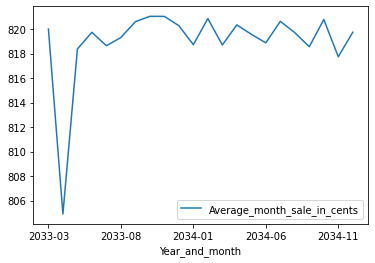

In [40]:
data_sort_top1 = data_sort_new[data_sort_new['merchant'] == '5608f200cf']
data_sort_top1_month = data_sort_top1.drop_duplicates(subset=['Year_and_month'], keep='first')
data_sort_top1_month.head(5)
data_sort_top1_month.plot(x = 'Year_and_month', y = 'Average_month_sale_in_cents')

<AxesSubplot:xlabel='Quarter'>

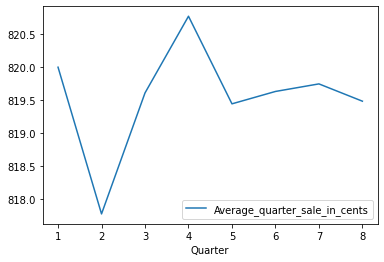

In [41]:
data_sort_top1_quarter = data_sort_top1.drop_duplicates(subset=['Quarter'], keep='first')
data_sort_top1_quarter.plot(x = 'Quarter', y = 'Average_quarter_sale_in_cents')

In [42]:
data_sort_new.drop('Growth_rates_by_month', axis=1, inplace=True)
data_sort_new.drop('Merchant_quarter', axis=1, inplace=True)
data_sort_new.drop('Year_and_month', axis=1, inplace=True)

data_sort_new['Retention_rate_by_month (%)'] = data_sort_new['Retention_rate_by_month (%)'] * 100
data_sort_new['Retention_rate_by_quarter (%)'] = data_sort_new['Retention_rate_by_quarter (%)'] * 100
data_sort_new['Total_retention_rate (%)'] = data_sort_new['Total_retention_rate (%)'] * 100
data_sort_new['Retention_rate_trend_by_quarter (%)'] = data_sort_new['Retention_rate_trend_by_quarter (%)'] * 100

In [43]:
data_sort_last = data_sort_new.drop_duplicates(subset=['merchant'], keep='last')

In the following part, I am using the intuitive way to observe any merchant that has already churned. I keep track the last trade time as well as the total trade count. If there are more than 100 trades for the entire two years span, but the last trade occurs not in 2034 July to December, which are the last two quarters of the time span, then I assume that this merchant has already churned. I set the threshold of 100 because there might be some merchants that only happen a few trades with Stripe and I can not decide whether this merchant is churned even if his last trade is not occuring in the last two quarters.

<AxesSubplot:>

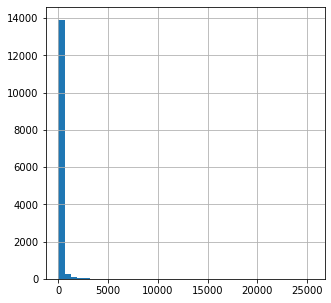

In [44]:
data_sort_last['Frequency'].hist(bins=40, figsize=(5, 5))

In [45]:
def check_last_trade(df):
    val = df['Quarter']
    if val not in [7,8]:
        if df['Frequency'] > 100:
            return 1
        else: return 0
    else: return 0

In [46]:
data_sort_last['last_trade'] = data_sort_last.apply(check_last_trade, axis=1)

<AxesSubplot:>

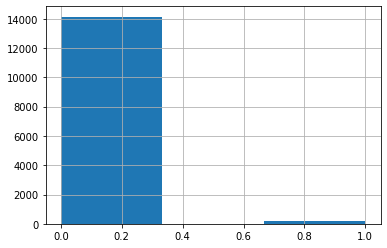

In [47]:
data_sort_last['last_trade'].hist(bins=3)

In [48]:
lst_on_last = data_sort_last.columns.tolist()
lst_on_last.remove('merchant')
lst_on_last.remove('last_trade')
data_sort_last.drop(lst_on_last, axis=1, inplace=True)
data_sort_new = pd.merge(data_sort_new, data_sort_last, on='merchant' ,how='left')

data_sort and data_sort_new are two dataframes before and after data preprocessing and data augmentation.

In [49]:
data_sort.head()

merchant                time  amount_usd_in_cents Year_and_month  \
983460   5608f200cf 2033-03-29 21:21:57                  820        2033-03   
1306769  5608f200cf 2033-04-09 19:52:45                  382        2033-04   
166087   5608f200cf 2033-04-10 02:23:28                  438        2033-04   
420264   5608f200cf 2033-04-11 00:00:52                  820        2033-04   
1113002  5608f200cf 2033-04-11 00:45:22                  820        2033-04   

         Frequency  Year  Month  
983460       25512  2033      3  
1306769      25512  2033      4  
166087       25512  2033      4  
420264       25512  2033      4  
1113002      25512  2033      4

In [50]:
data_sort_new.head()

merchant                time  amount_usd_in_cents  Frequency  Year  \
0  5608f200cf 2033-03-29 21:21:57                  820      25512  2033   
1  5608f200cf 2033-04-09 19:52:45                  382      25512  2033   
2  5608f200cf 2033-04-10 02:23:28                  438      25512  2033   
3  5608f200cf 2033-04-11 00:00:52                  820      25512  2033   
4  5608f200cf 2033-04-11 00:45:22                  820      25512  2033   

   Month  Count_per_month  Rank_by_merchant  Retention_rate_by_month (%)  \
0      3                1                 1                          0.0   
1      4              167                 2                      16600.0   
2      4              167                 2                      16600.0   
3      4              167                 2                      16600.0   
4      4              167                 2                      16600.0   

   Total_retention_rate (%)  Quarter  Retention_rate_by_quarter (%)  \
0               -181.888849        1                       0.000000   
1               -181.888849        2                   -8263.432836   
2               -181.888849        2                   -8263.432836   
3               -181.888849        2                   -8263.432836   
4               -181.888849        2                   -8263.432836   

   Retention_rate_trend_by_quarter (%)  Average_count_by_quarter  \
0                             0.571279                  1.000000   
1                             0.571279                543.666667   
2                             0.571279                543.666667   
3                             0.571279                543.666667   
4                             0.571279                543.666667   

   Average_total_sale_in_cents  Average_month_sale_in_cents  \
0                   819.675878                   820.000000   
1                   819.675878                   804.898204   
2                   819.675878                   804.898204   
3                   819.675878                   804.898204   
4                   819.675878                   804.898204   

   Average_quarter_sale_in_cents  last_trade  
0                     820.000000           0  
1                     817.770693           0  
2                     817.770693           0  
3                     817.770693           0  
4                     817.770693           0

In [51]:
data_sort_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1513719 entries, 0 to 1513718
Data columns (total 18 columns):
 #   Column                               Non-Null Count    Dtype         
---  ------                               --------------    -----         
 0   merchant                             1513719 non-null  object        
 1   time                                 1513719 non-null  datetime64[ns]
 2   amount_usd_in_cents                  1513719 non-null  int64         
 3   Frequency                            1513719 non-null  int64         
 4   Year                                 1513719 non-null  int64         
 5   Month                                1513719 non-null  int64         
 6   Count_per_month                      1513719 non-null  int64         
 7   Rank_by_merchant                     1513719 non-null  int32         
 8   Retention_rate_by_month (%)          1513719 non-null  float64       
 9   Total_retention_rate (%)             1513719 non-null  fl

In the following parts, I am using this dataset to create models for predicting churning

In [52]:
data_sort_model = data_sort_new.copy()

In [53]:
data_sort_model.drop('time', axis=1, inplace=True)

For here, I am deciding whether the merchant is churning or not throughout this dataset. If the 'last_trade' column is 1, which means that the corresponding meachant has already churned, I return True. Otherwise, if the entire retention rate is positive, it should be not churning. If the rate is negative but the retention rate trend for the last three quarters is positive, then we should not consider it as churning because there is a potential sign that the retention rate is going up. Otherwise, the merchant is facing churning. The result is stored in the column 'Churn'. 

In [54]:
def determine_churn(df):
    if df['last_trade'] == 1:
        return True
    else:
        if df['Total_retention_rate (%)'] < 0:
            if df['Retention_rate_trend_by_quarter (%)'] >= 0:
                return False
            else:
                return True
        else:
            return False

In [55]:
data_sort_model_ignore = data_sort_model.drop_duplicates(subset=['merchant'], keep='first')
data_sort_model_ignore['Churn'] = data_sort_model_ignore.apply(determine_churn, axis=1)

In [56]:
data_sort_model_ignore.head()

merchant  amount_usd_in_cents  Frequency  Year  Month  \
0      5608f200cf                  820      25512  2033      3   
25512  53b3fbeae2                 1809      12178  2033     11   
37690  1ddaea9838                 1928      12042  2033      1   
49732  89e2d29885                  635      11969  2033      1   
61701  654930c922                10071      11222  2033      1   

       Count_per_month  Rank_by_merchant  Retention_rate_by_month (%)  \
0                    1                 1                          0.0   
25512               42                 1                          0.0   
37690              244                 1                          0.0   
49732               12                 1                          0.0   
61701            11013                 1                          0.0   

       Total_retention_rate (%)  Quarter  Retention_rate_by_quarter (%)  \
0                   -181.888849        1                       0.000000   
25512                -56.732229        4                    2357.142857   
37690                 -0.670304        1                      12.457338   
49732                -21.759595        1                      90.378007   
61701               -101.526987        1                     -99.936439   

       Retention_rate_trend_by_quarter (%)  Average_count_by_quarter  \
0                                 0.571279                  1.000000   
25512                            11.935429                537.000000   
37690                            -6.240437                301.000000   
49732                             6.282885                373.333333   
61701                         -1573.333333               5510.000000   

       Average_total_sale_in_cents  Average_month_sale_in_cents  \
0                       819.675878                   820.000000   
25512                  4987.168665                  4884.214286   
37690                  3441.583209                  3155.237705   
49732                  1508.438466                  5586.416667   
61701                 13466.075120                 13465.274857   

       Average_quarter_sale_in_cents  last_trade  Churn  
0                         820.000000           0  False  
25512                    4736.799814           0  False  
37690                    3139.808416           0   True  
49732                    1574.630357           0  False  
61701                   13472.782396           0   True

In [57]:
data_sort_model_ignore['Churn'] = data_sort_model_ignore['Churn'].astype(int)

In [58]:
lst_on_final = data_sort_model_ignore.columns.tolist()
lst_on_final.remove('merchant')
lst_on_final.remove('Churn')
data_sort_model_ignore2 = data_sort_model_ignore.drop(lst_on_final, axis=1)
data_sort_model = pd.merge(data_sort_model, data_sort_model_ignore2, on='merchant' ,how='left')

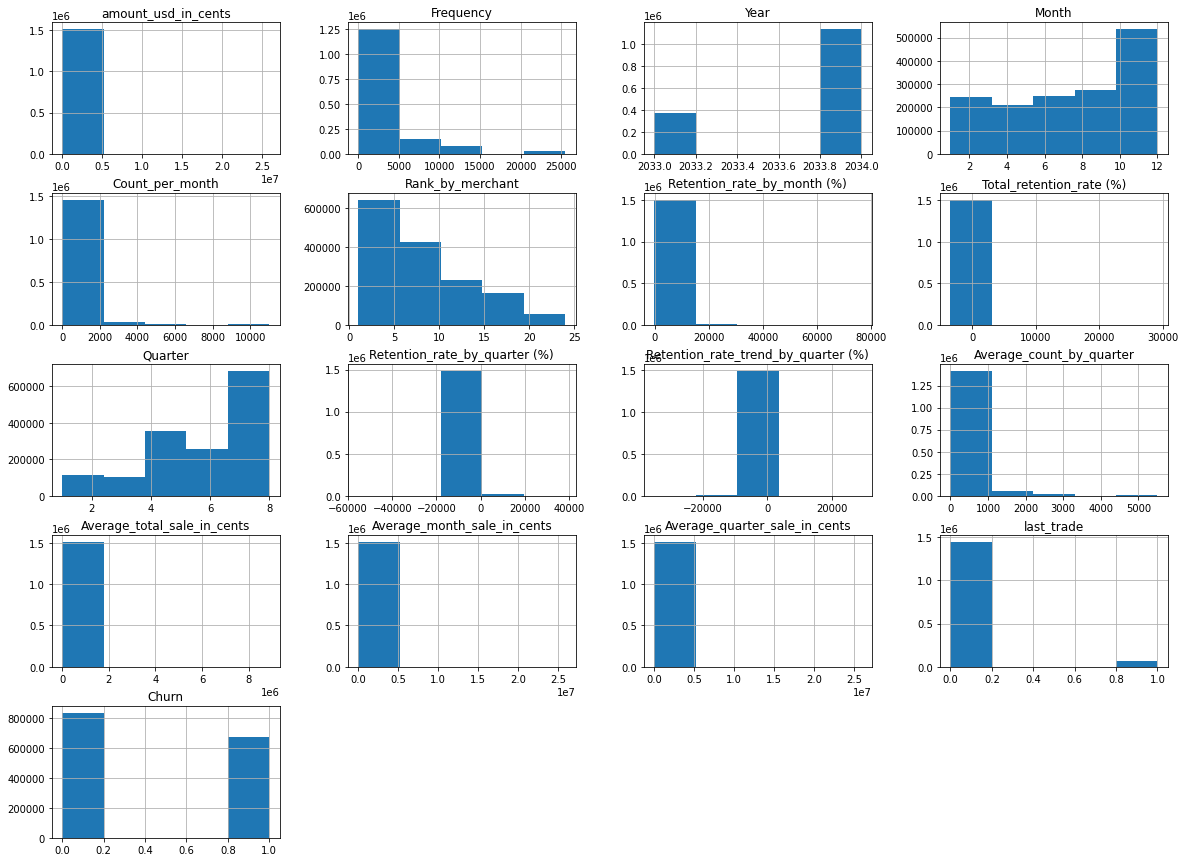

In [59]:
data_sort_model.hist(bins=5, figsize=(20,15))
plt.show()

Histogram of the churn label by the entire dataset. 0 means no churning while 1 means churning.

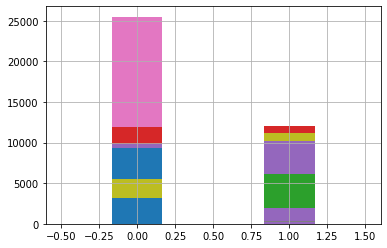

In [60]:
data_sort_model.groupby('merchant')["Churn"].hist(bins=3)
plt.show()

Histogram of the churn label by each merchant. 0 means no churning while 1 means churning. There are 10497 merchants that are not or have no potential to face churning, while there are 3854 merchants that are or will have higher potential to face churning.

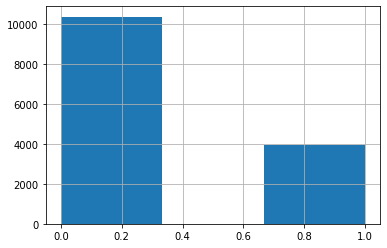

0    10382
1     3969
Name: Churn, dtype: int64

In [61]:
data_sort_model_ignore["Churn"].hist(bins=3)
plt.show()
data_sort_model_ignore["Churn"].value_counts()

Visualize the average transaction amount of the top 200 merchants sorted by the highest transaction frequency. I can infer from the histogram that most merchants have the average transaction amount between 0-10000 in cents.

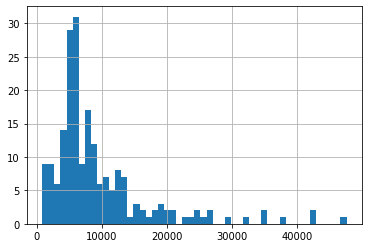

0           819.675878
25512      4987.168665
37690      3441.583209
49732      1508.438466
61701     13466.075120
              ...     
662619    29544.937102
664034     5237.399576
665448     4422.370746
666829     5597.100366
668194    19836.132062
Name: Average_total_sale_in_cents, Length: 200, dtype: float64

In [62]:
data_sort_model_ignore["Average_total_sale_in_cents"].head(200).hist(bins=50)
plt.show()
data_sort_model_ignore["Average_total_sale_in_cents"].head(200)

Correlations of our variables to our target value, which is 'Churn' that we want to predict

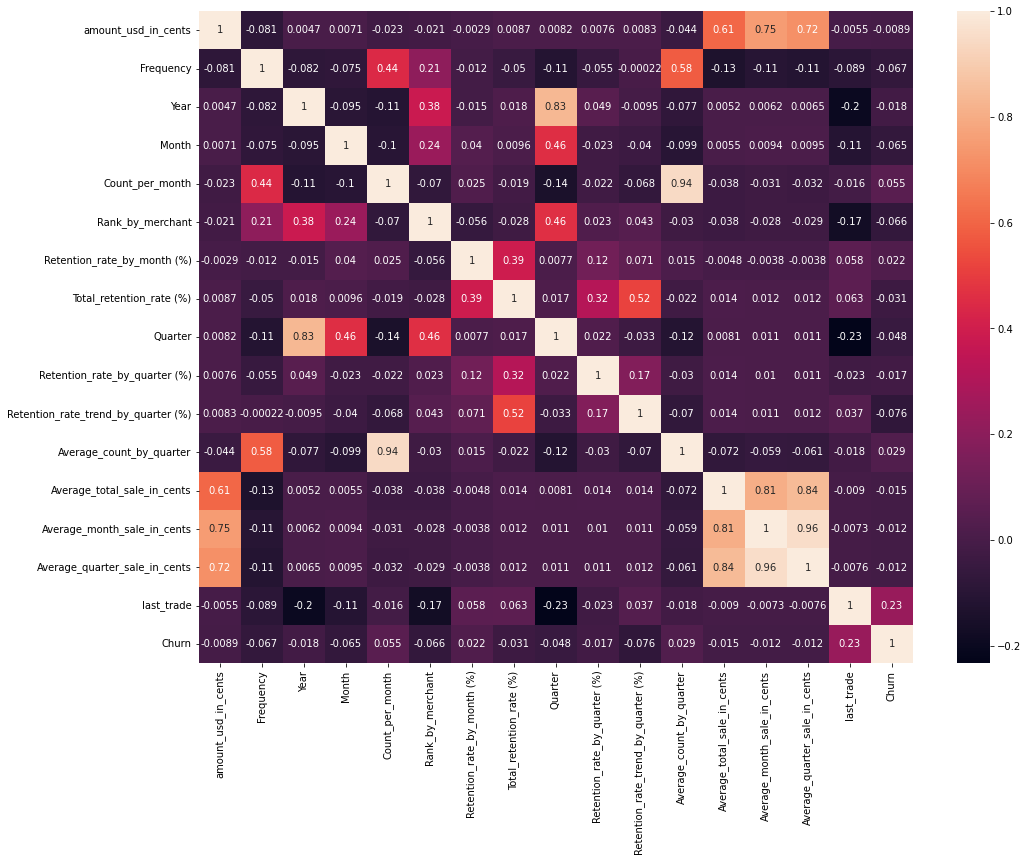

In [63]:
plt.figure(figsize=(16, 12))
heatmap_final = sns.heatmap(data_sort_model.corr(), annot=True)

In [64]:
data_sort_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1513719 entries, 0 to 1513718
Data columns (total 18 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   merchant                             1513719 non-null  object 
 1   amount_usd_in_cents                  1513719 non-null  int64  
 2   Frequency                            1513719 non-null  int64  
 3   Year                                 1513719 non-null  int64  
 4   Month                                1513719 non-null  int64  
 5   Count_per_month                      1513719 non-null  int64  
 6   Rank_by_merchant                     1513719 non-null  int32  
 7   Retention_rate_by_month (%)          1513719 non-null  float64
 8   Total_retention_rate (%)             1513719 non-null  float64
 9   Quarter                              1513719 non-null  int64  
 10  Retention_rate_by_quarter (%)        1513719 non-null  float64
 11

Label encode some variables

In [65]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

data_sort_model['merchant'] = labelencoder.fit_transform(data_sort_model['merchant'])
data_sort_model['Year'].astype(str)
data_sort_model['Year'] = labelencoder.fit_transform(data_sort_model['Year'])

In [66]:
data_sort_model.head()

merchant  amount_usd_in_cents  Frequency  Year  Month  Count_per_month  \
0      4806                  820      25512     0      3                1   
1      4806                  382      25512     0      4              167   
2      4806                  438      25512     0      4              167   
3      4806                  820      25512     0      4              167   
4      4806                  820      25512     0      4              167   

   Rank_by_merchant  Retention_rate_by_month (%)  Total_retention_rate (%)  \
0                 1                          0.0               -181.888849   
1                 2                      16600.0               -181.888849   
2                 2                      16600.0               -181.888849   
3                 2                      16600.0               -181.888849   
4                 2                      16600.0               -181.888849   

   Quarter  Retention_rate_by_quarter (%)  \
0        1                       0.000000   
1        2                   -8263.432836   
2        2                   -8263.432836   
3        2                   -8263.432836   
4        2                   -8263.432836   

   Retention_rate_trend_by_quarter (%)  Average_count_by_quarter  \
0                             0.571279                  1.000000   
1                             0.571279                543.666667   
2                             0.571279                543.666667   
3                             0.571279                543.666667   
4                             0.571279                543.666667   

   Average_total_sale_in_cents  Average_month_sale_in_cents  \
0                   819.675878                   820.000000   
1                   819.675878                   804.898204   
2                   819.675878                   804.898204   
3                   819.675878                   804.898204   
4                   819.675878                   804.898204   

   Average_quarter_sale_in_cents  last_trade  Churn  
0                     820.000000           0      0  
1                     817.770693           0      0  
2                     817.770693           0      0  
3                     817.770693           0      0  
4                     817.770693           0      0

Split into X and y, which are variable and target labels. There are two options for variable labels, either to keep or to leave out the merchant information.

In [67]:
data_y = data_sort_model['Churn'].copy()

#Option 1: keep the merchant:
#data_X = data_sort_model.drop('Churn', axis=1)

#Option 2: leave out the merchant:
data_X = data_sort_model.drop(['merchant','Churn'], axis=1)

Creating a simple pipeline for testing the dataset and model for the convenience of later use. Apply cross validation for model selection and draw confusion matrix for testing the model performance.

In [68]:
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['Not Chrun', 'Churn']
kfold = KFold(n_splits=10, random_state=0, shuffle=True) 

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)
    
def run_model(model, name, data_X, data_y):
    scores = cross_val_score(model, data_X, data_y, cv=kfold, n_jobs=-1)
    print('Cross Validation accuracy scores for {} is: {}'.format(name, scores))
    print('Cross Validation accuracy: {} +/- {}'.format(np.mean(scores),np.std(scores)))
    print('\n')

    clf = model.fit(data_X, data_y)
    y_pred = cross_val_predict(clf, data_X, data_y, cv=kfold, n_jobs=-1)

    print ("accuracy: ",accuracy_score(data_y, y_pred))
    print ("f1 score: ",f1_score(data_y, y_pred, average='macro'))
    print ("precision score: ",precision_score(data_y, y_pred, average='macro'))
    print ("recall score: ",recall_score(data_y, y_pred, average='macro'))
    print('\n')
    print(classification_report(data_y, y_pred))
    
    cm = confusion_matrix(data_y, y_pred)
    print(cm)
    title = 'Confusion Matrix for {}'.format(name)
    plot_confusion_matrix(cm, classes=class_names, title=title)

I am using two models, either logistic regression with L1 penalty or with L2 penalty. Since we want to keep the answer simple, I am only choosing the easiest model, but I have experiences in using random forest, XGboost and Neural network as well. I skip for the parameter tuning for this task, but I can still do it by gridsearch.

In [75]:
model1 = LogisticRegression(solver='liblinear', penalty='l1', max_iter=500)
model2 = LogisticRegression(solver='liblinear', penalty='l2', max_iter=500)

Cross Validation accuracy scores for Logistic Regression L1 penalty without scaling is: [0.63415955 0.63577808 0.63554686 0.63793172 0.63525619 0.63703327
 0.63493248 0.63492588 0.63618767 0.63806145]
Cross Validation accuracy: 0.6359813162681682 +/- 0.0012477536952651557


accuracy:  0.635998491133427
f1 score:  0.5643019272237589
precision score:  0.6965238380750314
recall score:  0.5998079887661726


              precision    recall  f1-score   support

           0       0.61      0.94      0.74    836898
           1       0.78      0.26      0.39    676821

    accuracy                           0.64   1513719
   macro avg       0.70      0.60      0.56   1513719
weighted avg       0.69      0.64      0.58   1513719

[[788385  48513]
 [502483 174338]]


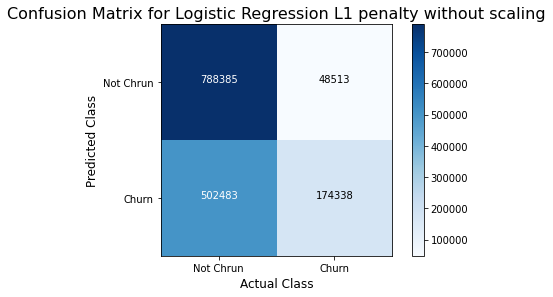

In [76]:
name = 'Logistic Regression L1 penalty without scaling'
run_model(model1, name, data_X, data_y)

Cross Validation accuracy scores for Logistic Regression L2 penalty without scaling is: [0.56767434 0.5697487  0.56355865 0.59881616 0.56539519 0.56916074
 0.5712351  0.56417303 0.5625545  0.56445422]
Cross Validation accuracy: 0.5696770634293143 +/- 0.010098861068776608


accuracy:  0.569677066879652
f1 score:  0.43178275667516286
precision score:  0.602317805485247
recall score:  0.5234353338966361


              precision    recall  f1-score   support

           0       0.57      0.96      0.71    836898
           1       0.64      0.09      0.15    676821

    accuracy                           0.57   1513719
   macro avg       0.60      0.52      0.43   1513719
weighted avg       0.60      0.57      0.46   1513719

[[804013  32885]
 [618503  58318]]


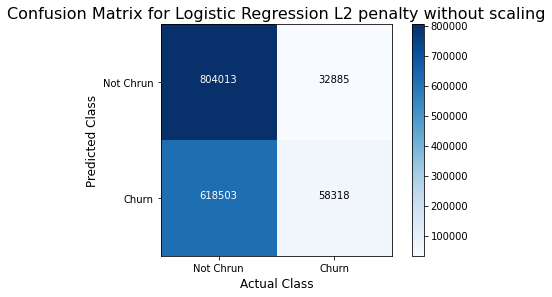

In [77]:
name = 'Logistic Regression L2 penalty without scaling'
run_model(model2, name, data_X, data_y)

For here, I am testing whether standard scaling the data has any improvement to the model performance. So there are a total of 4 cases.

In [78]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_X_std = scaler.fit_transform(data_X)

Cross Validation accuracy scores for Logistic Regression L1 penalty with scaling is: [0.63239569 0.63411331 0.63447665 0.63726449 0.63327432 0.63615464
 0.6334725  0.63320826 0.63470127 0.63660807]
Cross Validation accuracy: 0.6345669189863838 +/- 0.0015370346692724305


accuracy:  0.6347981362458951
f1 score:  0.5621402956869114
precision score:  0.695650296777035
recall score:  0.5984121300946266


              precision    recall  f1-score   support

           0       0.61      0.94      0.74    836898
           1       0.78      0.25      0.38    676821

    accuracy                           0.63   1513719
   macro avg       0.70      0.60      0.56   1513719
weighted avg       0.69      0.63      0.58   1513719

[[788764  48134]
 [504679 172142]]


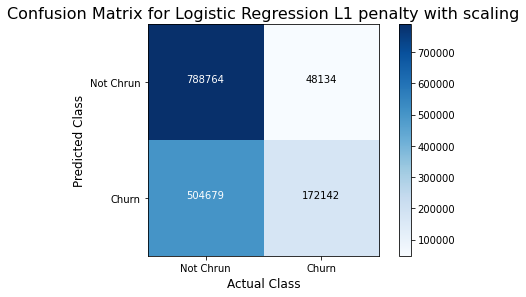

In [79]:
name = 'Logistic Regression L1 penalty with scaling'
run_model(model1, name, data_X_std, data_y)

Cross Validation accuracy scores for Logistic Regression L2 penalty with scaling is: [0.63193325 0.63381603 0.63341305 0.63577808 0.63309595 0.63598948
 0.63330735 0.63288455 0.63429829 0.63592102]
Cross Validation accuracy: 0.6340437041995978 +/- 0.0013442808168294745


accuracy:  0.6340437029594
f1 score:  0.5607327560101308
precision score:  0.6951895076147252
recall score:  0.5975239695804585


              precision    recall  f1-score   support

           0       0.61      0.94      0.74    836898
           1       0.78      0.25      0.38    676821

    accuracy                           0.63   1513719
   macro avg       0.70      0.60      0.56   1513719
weighted avg       0.69      0.63      0.58   1513719

[[789079  47819]
 [506136 170685]]


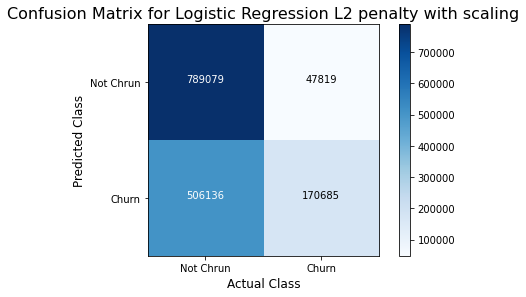

In [80]:
name = 'Logistic Regression L2 penalty with scaling'
run_model(model2, name, data_X_std, data_y)